# 1. Scrapping Movie Data from IMDB
To scrap movie data we found the popular http://www.imdb.com website's legally free database which includes potentially every movie ever produced with information published studio, genre, crew/actors and more.



In [2]:
import gzip
import pandas as pd
from io import BytesIO

## Reading the compressed file and building a dataframe
This database is compressed into a tsv.gz file so we first uncompress it using gzip and save it as a BytesIO object.
Now that we have BytesIO object, which is a ``.tsv file`` , we can load it into a dataframe, with ```pd.read_csv()``` with a little change of the seperator from comma to tab.

In [3]:
gzip_file = gzip.open("./src_data/title.basics.tsv.gz","rb")
csv_file = BytesIO(gzip_file.read())
gzip_file.close()
data : pd.DataFrame = pd.read_csv(csv_file,sep="\t")


D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Cleaning the dataframe
The dataframe we created consists of every movie / short / TV episode ever aired. We will perform some cleaning including dropping irrelevant columns and treating only the movies for later research.

## The columns we care about
We are interested in tconst which is an exclusive identifier for each movie, primaryTitle and originalTitle which are the given and formal movie names, runtimeMinutes and genres.

In [4]:
data.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


### Quick note
This is a really huge database with up to 7.85 million entries, most of them will render irrelevant.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7850754 entries, 0 to 7850753
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 539.1+ MB


## Filtering 'titleType' colunmn
We are only interested in movies so we filter the titleType to movies only and then dropping the colunmn

In [6]:
data = data[data["titleType"].apply(lambda t: t=="movie")]
data= data.drop("titleType",axis=1)

## Filtering 'startYear' column
This dataframe includes entries from early 1900 to even the future with yet to be released movies.
We will try to pinpoint the really releveant earliest start year later in this project but for sure we know we need already published movies so the future is really irrelevant.
What we will do is filtering movies from 1900 to 2020 (including) since 2021 is yet to end and also because of the coronavirus many trends would probably fail in this year. We will also filter nan startYears since it wouldn't help us later at all.

In [7]:
#This function will try converting the value of the year to int and then check it's validity under the constraints
#if the conversion fails that means that the value can't be parsed so it msut be either a nan or some other junky value 
def filterYear(year:str)->bool:
    try:
        return 1900<=int(year)<2021
    except:
        return False
    
data = data[data["startYear"].apply(filterYear)]

### Quick note
Most of the entries were NOT movies and it makes sense since there are far more TV episodes, shorts, video games etc, than movies, now the dataframe dropped in size massively to only about 500K entries

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492524 entries, 498 to 7850704
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          492524 non-null  object
 1   primaryTitle    492524 non-null  object
 2   originalTitle   492524 non-null  object
 3   isAdult         492524 non-null  object
 4   startYear       492524 non-null  object
 5   endYear         492524 non-null  object
 6   runtimeMinutes  492524 non-null  object
 7   genres          492524 non-null  object
dtypes: object(8)
memory usage: 33.8+ MB


## Dropping 'endYear' column
A derivative of filtering to movies only is also filtering endYear since the movies only have a release date without ongoing content, thus all entries of endYear are natually nan.

In [9]:
#data.drop("titleType",inplace=True,axis=1)
data = data.drop("endYear",axis=1)

## Is 'isAdult' relevant?
We noticed that there is a column for the compatability to adults only with a boolean value of 0,1 (and probably from earlier/later updates with '0', '1' outlier strings) 

In [10]:
data.isAdult.unique()


array([0, 1, '0', '1'], dtype=object)

We check how the isAdult value is distributed after fixing the string-integer incompatability and plotting to a pie chart after normalizing the counts

0    0.982037
1    0.017963
Name: isAdult, dtype: float64

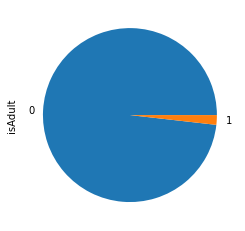

In [11]:
isAdult = data["isAdult"].apply(lambda n:int(n))
isAdult = isAdult.value_counts(normalize=True)
isAdult.plot(kind="pie")
isAdult

## Dropping 'isAdult'
We decided to drop the 'isAdult' column since the distribution for adult movies is less than 2% so it seems irrelevant to take it into consideration for later research.

In [12]:
data = data.drop("isAdult",axis=1)

# Final cleaning and fixing nans


## Dropping nan 'startYear' movies
The goal of this project is to check how influencial some movies were along the years so movies with a nan in the year column is probably less known and not really helpful for this goal. This drop narrows down the dataset to about 425K results.


In [13]:
print("The % of \"yearless\" movies:", data[data.genres=="\\N"].shape[0] / data. shape[0],"\n")
data = data[data.genres!="\\N"]
data.info()

The % of "yearless" movies: 0.13530711193769238 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425882 entries, 570 to 7850704
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          425882 non-null  object
 1   primaryTitle    425882 non-null  object
 2   originalTitle   425882 non-null  object
 3   startYear       425882 non-null  object
 4   runtimeMinutes  425882 non-null  object
 5   genres          425882 non-null  object
dtypes: object(6)
memory usage: 22.7+ MB


## Dropping (presumably) far less known movies
We decided to also drop movies with nan in 'runtimeMinutes' since it is really a simple value to fill in, and if it is not present that means the movie is not that popular. This operation seals the narrowing to 330K movies.

In [14]:
data = data[data["runtimeMinutes"].apply(lambda n:n!="\\N")]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329887 entries, 570 to 7850704
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          329887 non-null  object
 1   primaryTitle    329887 non-null  object
 2   originalTitle   329887 non-null  object
 3   startYear       329887 non-null  object
 4   runtimeMinutes  329887 non-null  object
 5   genres          329887 non-null  object
dtypes: object(6)
memory usage: 17.6+ MB


# Conclusion of movie data acquiring and cleansing
This dataset was reduced from arount 8M entries to about 330K entries leaving us with the really potentially good 'fruits'.
One last thing to do is to save it for later use.

In [15]:
data.to_csv("./output_data/fixed.title.basics.csv",index=False)